<a href="https://colab.research.google.com/github/ALiMehran01/Data-Science_Algorithm/blob/main/LAB_15_20sw008_productRecoomend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LAB no:15 Create your own recommendations systems of your own choice such as for ecommerce, movie, music, or books.
##i have choosed e-commerce recomendation
##RollNO: 20SW008
###section: 2

Here i have used an amazon dataset on user ratings for electronic products, this dataset doesn't have any headers. To avoid biases, each product and user is assigned a unique identifier instead of using their name or any other potentially biased information.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds # for sparse matrices

In [2]:
#Import the data set
df = pd.read_csv('/content/ratings_Electronics.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe


#EDA - Exploratory Data Analysis
check for -
shape,
datatype,
missing values,
finally get the summary and check,

rating distribution.
number of users and products.
Users with highest no of ratings.

In [4]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  463800
No of columns =  3


#datatypes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463800 entries, 0 to 463799
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  463800 non-null  object 
 1   prod_id  463800 non-null  object 
 2   rating   463800 non-null  float64
dtypes: float64(1), object(2)
memory usage: 10.6+ MB


#Missing value analysis

In [6]:
# Find number of missing values in each column
df.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

#Summary

In [7]:

# Summary statistics of 'rating' variable
df['rating'].describe()

count    463800.000000
mean          3.972958
std           1.400396
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

#Rating distribution

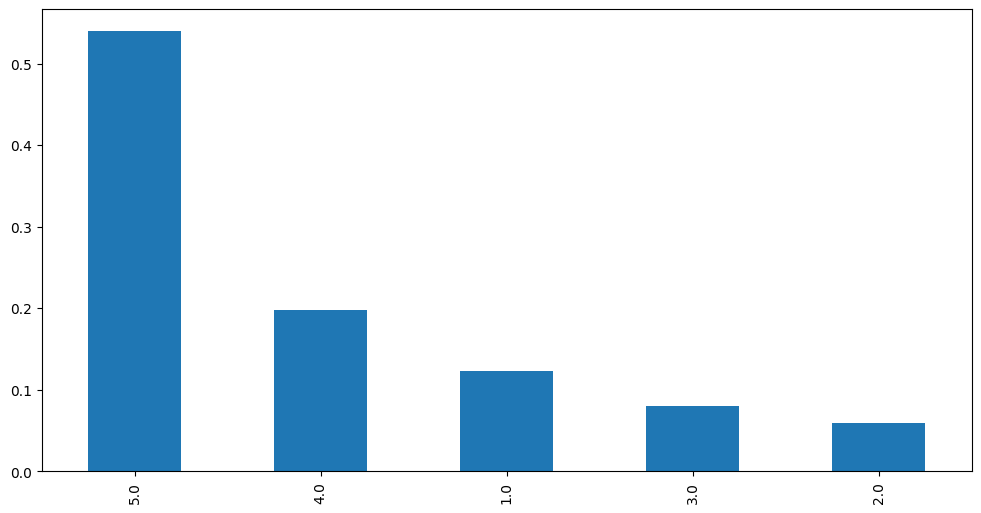

In [8]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

#No of unique users and items

In [9]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())


Number of unique USERS in Raw data =  377092
Number of unique ITEMS in Raw data =  28714


#Users with most no of rating

In [10]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated


user_id
A5JLAU2ARJ0BO     284
A231WM2Z2JL0U3    247
A25HBO5V8S8SEA    154
AKT8TGIT6VVZ5      84
A6FIAB28IS79       76
A2AEZQ3DGBBLPR     76
A11D1KHM7DVOQK     75
AT6CZDCP4TRGA      72
A2B7BUH8834Y6M     71
ABH9D1TEOJ56E      64
dtype: int64

#Pre-Processing

In [11]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [12]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())


The number of observations in the final data = 1640
Number of unique USERS in the final data =  18
Number of unique PRODUCTS in the final data =  1425


#Checking the density of the rating matrix

In [13]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (18, 1425)
given_num_of_ratings =  1640
possible_num_of_ratings =  25650
density: 6.39%


prod_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B0002CEUMU,B0002CPBUK,B0002DCJT0,B0002DG0OA,B0002DG9XW,B0002DGAO0,B0002DRNQO,B0002DV9DM,B0002E50MC,B0002EQUL2
user_id,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##Rank Based Recommendation System

In [14]:
#Calculate the average rating for each product
average_rating = df_final.groupby('prod_id').mean()['rating']

#Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='avg_rating',ascending=False)

final_rating.head()

,avg_rating,rating_count
prod_id,,
B00006HCJ4,5.0,1
B000066S2B,5.0,1
B000065UWF,5.0,1
B000065V15,5.0,1
B000066AZ7,5.0,1


In [15]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]

    #Sorting values w.r.t average rating
    recommendations = recommendations.sort_values('avg_rating',ascending=False)

    return recommendations.index[:n]


#Recommending top 5 products with 50 minimum interactions based on popularity

In [16]:

list(top_n_products(final_rating, 5, 50))


[]

###Collaborative Filtering based Recommendation System
User based collaborative filtering

In [17]:
final_ratings_matrix.head()

prod_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B0002CEUMU,B0002CPBUK,B0002DCJT0,B0002DG0OA,B0002DG9XW,B0002DGAO0,B0002DRNQO,B0002DV9DM,B0002E50MC,B0002EQUL2
user_id,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:

final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B0002CEUMU,B0002CPBUK,B0002DCJT0,B0002DG0OA,B0002DG9XW,B0002DGAO0,B0002DRNQO,B0002DV9DM,B0002E50MC,B0002EQUL2
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#function 2 recommend products

In [19]:
import numpy as np

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):

    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')

    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]

    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))


###Recommending top 5 proudcts to user id 121

In [ ]:
#Enter 'user index' and 'num_recommendations' for the user
recommend_items(121,final_ratings_sparse,preds_matrix,5)


Below are the recommended products for user(user_id = 121):

Recommended Products
28761    2.414390
39003    1.521306
41420    1.309224
40158    1.200111
33819    1.126866
Name: user_predictions, dtype: float64

##Evaluating the model

In [21]:

final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B0002CEUMU,B0002CPBUK,B0002DCJT0,B0002DG0OA,B0002DG9XW,B0002DGAO0,B0002DRNQO,B0002DV9DM,B0002E50MC,B0002EQUL2
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###End of lab #15 open ended lab